In [16]:
# 1.gutenbergからテキストを読みこんで、段落ごとに、変数に入れる
# 2.その後、段落ごとに大規模自然言語LLMで単語埋め込みword embeddingsをしてテキストを数値化して、
# 3.総当たりでコサイン類似度を取って、可視化して影響の度合いを調べる
import os
from bs4 import BeautifulSoup
import pandas as pd
import codecs
import glob
import re
import numpy as np
import csv
import shutil

#ディレクトリの準備
dir='/content/'
folder='folder'
os.makedirs(dir+folder, exist_ok=True)

#テキストのダウンロード
#The Old Manse pg9221-h.zip
#The Piazza Tales pg15859-h.zip
data_source=['https://www.gutenberg.org/cache/epub/9221/pg9221-h.zip',
'https://www.gutenberg.org/cache/epub/15859/pg15859-h.zip']

header='https://www.gutenberg.org/cache/epub/'
for i in data_source:
  j=re.sub(header, '', i)
  j=re.sub(r'[0-9]+\/', '', j)
  if not os.path.isfile(folder+'/'+j):
    !wget -O $folder/$j $i
    !unzip -d $folder -o $folder/$j



In [17]:
#前処理
#注削除・前後の空白削除（タイトルの時）
text=''
author=''
title=''
texts=''
def preprocess_1(text=text):
  text=text.strip()
  #[]で囲まれた数字を消す
  text=re.sub(r'\[[0-9:]+\]', '', text)
  return text

#注削除・前後の空白・行番号削除（本文の時）
def preprocess_2(text=text):
  text=preprocess_1(text)
  text=re.sub(r'[0-9]+$', '', text)
  return text

In [18]:
#テクストを読み取り、前処理
#最終的なテーブル
texts_table=[]
texts_table_temp=[]
num=0
text_temp=[]
file_list=[]
#ディレクトリの中のテクストを一つずつ読み込む
for v in glob.glob(dir+folder+'/*.html'):
  with open(v) as f:
    text=f.read()
    i = re.sub(dir+folder+'/','',v)
    i = re.sub(r'-images.html','',i)
    file_list.append(i)
    print(i)

    keytext='p'
    soup = BeautifulSoup(text,'lxml')
    elem = soup.find_all(keytext)

    exempt=['Title:', 'Author:', 'Release date:', 'Language:', 'Credits:',
            'Edwards, 321 Broadway.', '1856', 'Author of “Typee,”']
    def exempt_flag(text):
      sum = 0
      for q in exempt:
        if q in text:
          sum += 1
      return sum

    text_temp2=[]
    for i in elem:
      j=i.text
      if exempt_flag(j)==0:
        #前処理（[]で囲まれた数字や注や前後の空白などを消す）
        j=preprocess_1(j)
        j=preprocess_2(j)
        #テキストを仮の変数に追加
        text_temp2.append(j)
    #1ファイル分まとめて変数に追加
    text_temp.append(text_temp2)
print(text_temp)
#text_tempに各ファイルのテキストが入る text_temp[0], text_temp[1]など
#1.gutenbergからテキストを読みこんで、段落ごとに、変数に入れる作業終わり




pg9221
pg15859
[['Between two tall gate-posts of rough-hewn stone (the gate itself having fallen\nfrom its hinges at some unknown epoch) we beheld the gray front of the old\nparsonage, terminating the vista of an avenue of black-ash trees. It was now a\ntwelvemonth since the funeral procession of the venerable clergyman, its last\ninhabitant, had turned from that gateway towards the village burying-ground.\nThe wheel-track leading to the door, as well as the whole breadth of the\navenue, was almost overgrown with grass, affording dainty mouthfuls to two or\nthree vagrant cows and an old white horse who had his own living to pick up\nalong the roadside. The glimmering shadows that lay half asleep between the\ndoor of the house and the public highway were a kind of spiritual medium, seen\nthrough which the edifice had not quite the aspect of belonging to the material\nworld. Certainly it had little in common with those ordinary abodes which stand\nso imminent upon the road that every pas

In [19]:
elem[0]

<p><strong>Title</strong>: The Piazza Tales</p>

In [20]:
# 2.その後、段落ごとに大規模自然言語LLMで単語埋め込みword embeddingsをしてテキストを数値化

#わかりやすいように変数に入れる。The Old Manse->Old_Manse The Piazza Tales->Piazza
file_list2={'The Old Manse': 'pg9221', 'The Piazza Tales': 'pg15859'}
for i in range(len(file_list)):
  if file_list[i]==file_list2['The Old Manse']:
    Old_Manse=text_temp[i]
for i in range(len(file_list)):
  if file_list[i]==file_list2['The Piazza Tales']:
    Piazza=text_temp[i]





In [21]:
#テキスト結合
#numpyに変換し、テキスト部分のみ取り出して結合
#texts [volume, title, id, text]
texts_all1 = np.array(Old_Manse)
texts_all2 = np.array(Piazza)
texts_all = np.append(texts_all1,texts_all2,axis=0)
#リストに戻す
#
texts_all=texts_all.tolist()
texts_table=texts_all

In [22]:
#SentenceBERTによる分析
#SentenceBERTをロード
import numpy as np
!pip install sentence-transformers
from sentence_transformers import SentenceTransformer
from sentence_transformers.util import cos_sim
#モデルにはMPNetを使う
mpnet = SentenceTransformer('all-mpnet-base-v2')
mpnet


SentenceTransformer(
  (0): Transformer({'max_seq_length': 384, 'do_lower_case': False}) with Transformer model: MPNetModel 
  (1): Pooling({'word_embedding_dimension': 768, 'pooling_mode_cls_token': False, 'pooling_mode_mean_tokens': True, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False, 'pooling_mode_weightedmean_tokens': False, 'pooling_mode_lasttoken': False, 'include_prompt': True})
  (2): Normalize()
)

In [23]:
#SentenceBERTを使って各作品の文章ベクトルを得る
embeddings = mpnet.encode(texts_table)
print(embeddings)
print(len(embeddings))

[[ 0.01960923  0.04855732 -0.00162667 ...  0.0132503   0.03504401
  -0.02372012]
 [ 0.0153053   0.07639029  0.00048356 ...  0.00787515  0.03211101
  -0.03456296]
 [ 0.01103462  0.0578352  -0.02708288 ...  0.02938362  0.01530892
  -0.03224195]
 ...
 [-0.01857787 -0.0689407  -0.00360162 ...  0.03126124 -0.00392862
  -0.03532697]
 [-0.00125207  0.07235798 -0.00452131 ...  0.00695724 -0.03041727
  -0.03468563]
 [ 0.00797936  0.05367057 -0.01436626 ...  0.02757352  0.02966736
  -0.0389391 ]]
1211


In [24]:
#段落数
length_Old_Manse=len(Old_Manse)
length_Piazza=len(Piazza)
print(length_Old_Manse)
print(length_Piazza)
#数値化したデータを作品ごとに分ける
table_Old_Manse=embeddings[:length_Old_Manse]
table_Piazza=embeddings[length_Old_Manse:]

#2.その後、段落ごとに大規模自然言語LLMで単語埋め込みword embeddingsをしてテキストを数値化終わり


46
1165


In [25]:
# 3.総当たりでコサイン類似度を取って、可視化して影響の度合いを調べる
#コサイン類似度をとる
#sim = np.zeros((len(texts_table), len(texts_table)))
#for i in range(len(texts_table)):
#    sim[i:,i] = cos_sim(embeddings[i], embeddings[i:])
#np.fill_diagonal(sim,-1)
sim = np.zeros((len(table_Old_Manse), len(table_Piazza)))
for i in range(len(table_Old_Manse)):
  for j in range(len(table_Piazza)):
    sim[i,j] = cos_sim(table_Old_Manse[i], table_Piazza[j])

print(sim)
print(sim.shape)

[[0.45651746 0.65923834 0.67079973 ... 0.21775539 0.50076485 0.42965502]
 [0.42897004 0.63153714 0.5574044  ... 0.18434998 0.46030194 0.45340312]
 [0.48306149 0.69660991 0.5962491  ... 0.20750038 0.44803071 0.37882441]
 ...
 [0.51350361 0.71112776 0.65830564 ... 0.27066267 0.53365266 0.45783526]
 [0.43988425 0.58433449 0.47945338 ... 0.20751475 0.35168982 0.41514546]
 [0.35453111 0.5670535  0.54048383 ... 0.30913007 0.40711528 0.42634553]]
(46, 1165)


In [26]:
#保存
np.save(dir+'embeddings', embeddings)
np.save(dir+'sim', sim)
!cp $dir/embeddings.npy '/content/drive/MyDrive/embeddings.npy'
!cp $dir/sim.npy '/content/drive/MyDrive/sim.npy'


cp: cannot create regular file '/content/drive/MyDrive/embeddings.npy': No such file or directory
cp: cannot create regular file '/content/drive/MyDrive/sim.npy': No such file or directory


In [27]:
#描画用のラベル
titles_table_Old_Manse=[]
titles_table_Piazza=[]
for i in range(sim.shape[0]):
  titles_table_Old_Manse.append(str(i))
for i in range(sim.shape[1]):
  titles_table_Piazza.append(str(i))



<Axes: >

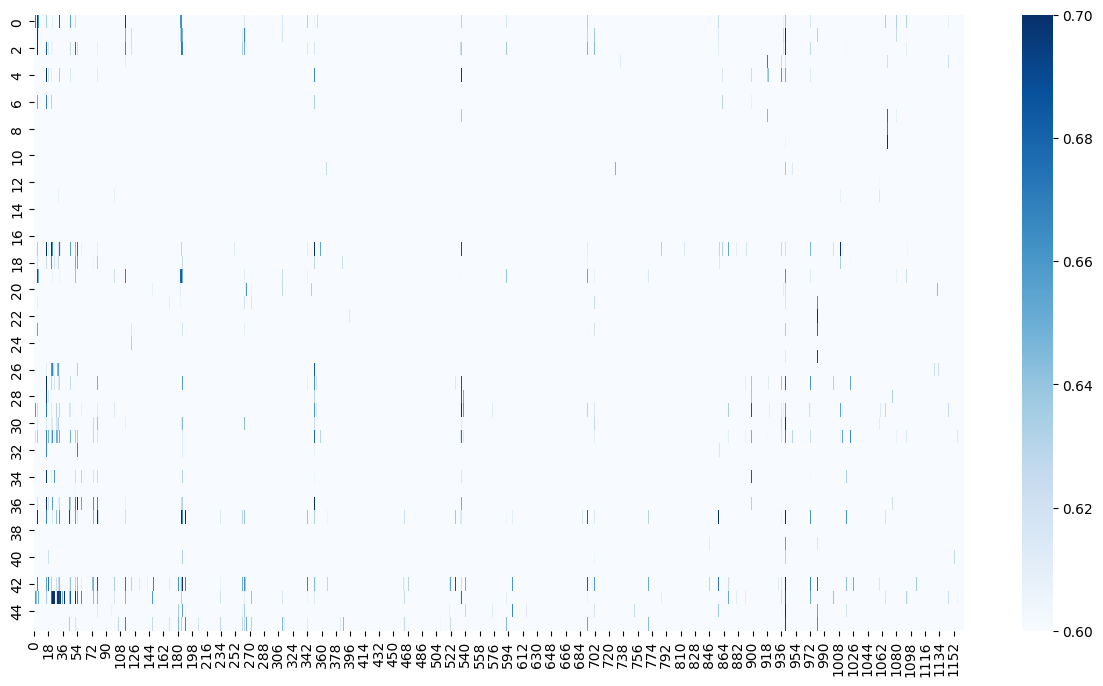

In [28]:
#ヒートマップで描画 0.6-0.8を描画
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
df = pd.DataFrame(data=sim, index=titles_table_Old_Manse, columns=titles_table_Piazza)
plt.figure(figsize=(15, 8))
sns.heatmap(df,vmax=0.7, vmin=0.6, cmap='Blues')
plt.xlabel('Melville, The Piazza Tales')
plt.ylabel('Hawthorn, The Old Manse')

In [29]:
#類似度が上位n件の組を表示
r=sim.shape[1]
simcopy=sim.flatten()
k=10
max_table=[]
for l in range(k):
  maxpos=np.argmax(simcopy)
  i,j = divmod(maxpos,r)
  maxval=sim[i,j]
  a = [i, j, maxval, Old_Manse[i], Piazza[j]]
  max_table.append(a)
  simcopy[maxpos]=0

print("類似度の高い順"+str(k)+"件: ")
for l in range(k):
  print("----------------------------------------------------")
  print("類似度: "+str(max_table[l][2])+" 順位: "+str(l+1)+" 位置:["+str(max_table[l][0])+","+str(max_table[l][1])+"]")
  print("----------------------------------------------------")
  print("Smithのテキスト: ")
  print(max_table[l][3])
  print("\n")
  print("Darwinのテキスト: ")
  print(max_table[l][4])
  print("\n")

類似度の高い順10件: 
----------------------------------------------------
類似度: 0.7723207473754883 順位: 1 位置:[42,941]
----------------------------------------------------
Smithのテキスト: 
And now I begin to feel—and perhaps should have sooner felt—that we
have talked enough of the Old Manse. Mine honored reader, it may be, will
vilify the poor author as an egotist for babbling through so many pages about a
mossgrown country parsonage, and his life within its walls, and on the river,
and in the woods, and the influences that wrought upon him from all these
sources. My conscience, however, does not reproach me with betraying anything
too sacredly individual to be revealed by a human spirit to its brother or
sister spirit. How narrow-how shallow and scanty too—is the stream of
thought that has been flowing from my pen, compared with the broad tide of dim
emotions, ideas, and associations which swell around me from that portion of my
existence! How little have I told! and of that little, how almost noth